### Выбор локации для скважины

#### Описание проекта
Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину. \
Шаги для выбора локации обычно такие:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.


- Вам предоставлены пробы нефти в трёх регионах. 
- Характеристики для каждой скважины в регионе уже известны. 
- Постройте модель для определения региона, где добыча принесёт наибольшую прибыль.
- Проанализируйте возможную прибыль и риски техникой Bootstrap.

#### Описание данных
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

#### Условия задачи:
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода.\
Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%.\
Среди них выбирают регион с наибольшей средней прибылью.

#### План работы:
1. Загузка и подготовка данных;
2. обучение и проверка модели;
3. подготовка к расчету прибыли;
4. расчет прибыли;
5. подсчет рисков и прибыли по регионам;
6. Итоговый вывод.

#### Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [2]:
try:
    df_geo_1 = pd.read_csv('/datasets/geo_data_0.csv')
    df_geo_2 = pd.read_csv('/datasets/geo_data_1.csv')
    df_geo_3 = pd.read_csv('/datasets/geo_data_2.csv')
    
except:
    df_geo_1 = pd.read_csv('geo_data_0.csv')
    df_geo_2 = pd.read_csv('geo_data_1.csv')
    df_geo_3 = pd.read_csv('geo_data_2.csv')

Функция для изучения данных

In [3]:
def inform(data):
    # Вывод информации о датасете
    print("Информация о датасете:")
    data.info()
    
    # Разделительная строка
    print("\n" + "="*50 + "\n")
    
    # Вывод первых нескольких строк датасета
    print("Первые несколько строк датасета:")
    display(data.head())
    
    # Разделительная строка
    print("\n" + "="*50 + "\n")
    
    #describe
    print('Описательная статистика:')
    display(data.drop('id',axis=1).describe())

    # Разделительная строка
    print("\n" + "="*50 + "\n")
    display(f'Количествово дубликатов:{data.duplicated().sum()}')   

    # Разделительная строка
    print("\n" + "="*50 + "\n")

    print('гистограмма численных показателей')
    data.hist(figsize=(15, 7), bins=50)

Функция для корреляционного анализа

In [4]:
def corr_matrix(data):    
    corr_matrix = data.corr()
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm");
    plt.show()

##### Просмотр данных

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Первые несколько строк датасета:


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647




Описательная статистика:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


'Количествово дубликатов:0'



гистограмма численных показателей


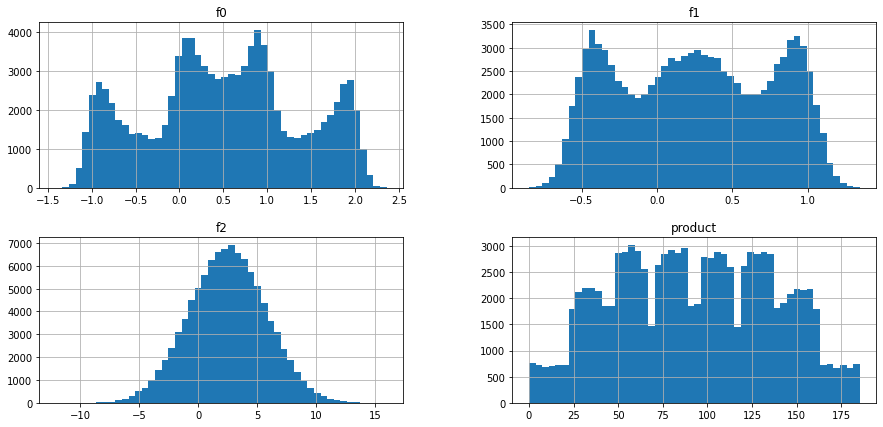

In [5]:
inform(df_geo_1)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Первые несколько строк датасета:


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305




Описательная статистика:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


'Количествово дубликатов:0'



гистограмма численных показателей


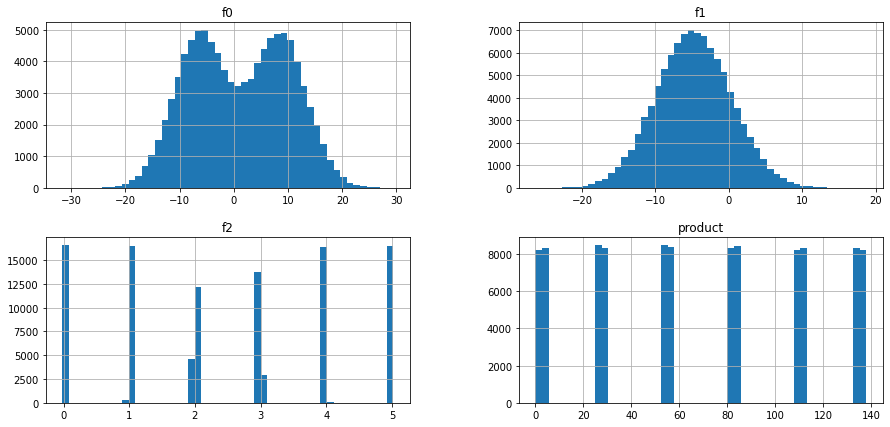

In [6]:
inform(df_geo_2)

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Первые несколько строк датасета:


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746




Описательная статистика:


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


'Количествово дубликатов:0'



гистограмма численных показателей


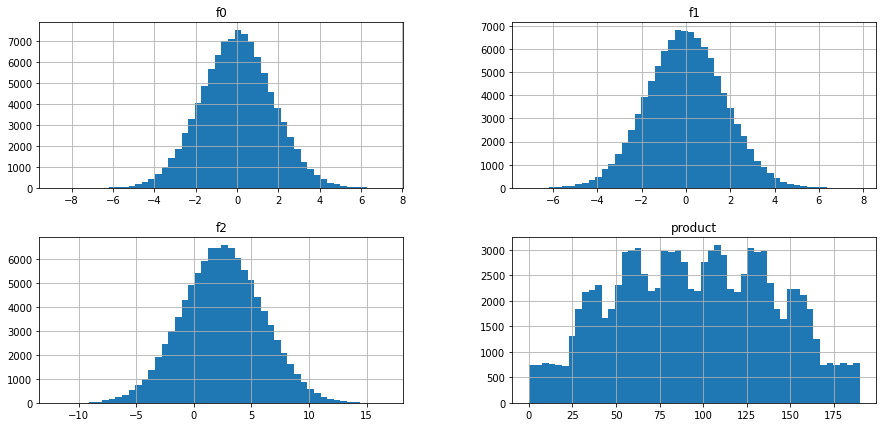

In [7]:
inform(df_geo_3)

##### Корреляционные матрицы

Сразу удалим столбец 'id' - он не несёт в себе в нашем счучае ничего, кроме шума.

In [8]:
df_geo_1=df_geo_1.drop(['id'], axis=1)
df_geo_2=df_geo_2.drop(['id'], axis=1)
df_geo_3=df_geo_3.drop(['id'], axis=1)

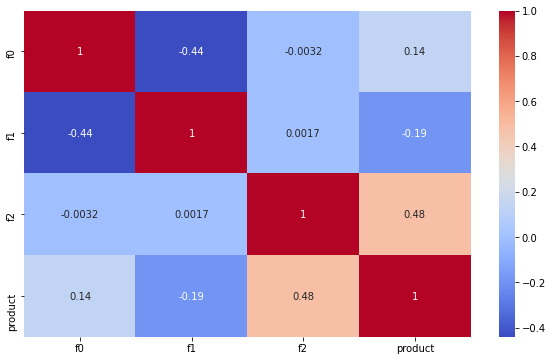

In [9]:
corr_matrix(df_geo_1)

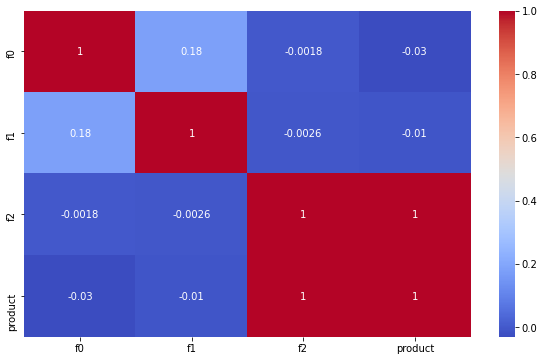

In [10]:
corr_matrix(df_geo_2)

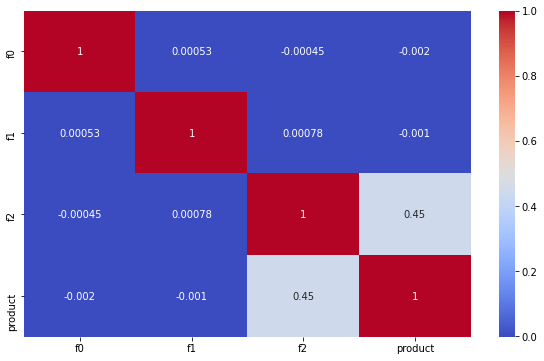

In [11]:
corr_matrix(df_geo_3)

**Промежуточный вывод:** как мы видим, в датафреймах нет дубликатов, но есть большой разброс значений, выраженный в стандартном отклонении.\
Особенно ярко выражено в столбцах f1, f2 и f3.\
Так же мы видим существенный разброс между датасетами регионов, что может в текущем виде может повредить качеству обучения. 


#### Обучение и проверка модели

In [12]:
names = ['1-го', '2-го', '3-го']
data = [df_geo_1,df_geo_2,df_geo_3]

# Словарь для хранения фактических и предсказанных значений
targets = {}

for name, df in zip(names, data):
    target = df['product']
    features = df.drop('product', axis=1)

    features_train, features_valid, target_train, target_valid = \
    train_test_split(features, target, test_size=.25, random_state=42)

    # Создание и обучение модели (используется pipeline)
    model = make_pipeline(StandardScaler(), LinearRegression())
    model.fit(features_train, target_train)
    
    # Предсказание и оценка модели
    predictions = pd.Series(model.predict(features_valid), index=target_valid.index, name='product_predicted')
    targets[name] = (target_valid, predictions)

    # Вывод результатов
    print(f'Для {name} региона:')
    actual_mean = targets[name][0].mean()
    predicted_mean = targets[name][1].mean()
    print(f'Средний запас фактического сырья = {actual_mean:.2f} тыс. баррелей')
    print(f'Средний запас предсказанного сырья = {predicted_mean:.2f} тыс. баррелей')
    print(f'Разница = {(1 - actual_mean / predicted_mean):.2%}')
    print(f'RMSE модели = {mean_squared_error(target_valid, targets[name][1], squared=False):.2f}')
    print()

Для 1-го региона:
Средний запас фактического сырья = 92.33 тыс. баррелей
Средний запас предсказанного сырья = 92.40 тыс. баррелей
Разница = 0.08%
RMSE модели = 37.76

Для 2-го региона:
Средний запас фактического сырья = 68.73 тыс. баррелей
Средний запас предсказанного сырья = 68.71 тыс. баррелей
Разница = -0.02%
RMSE модели = 0.89

Для 3-го региона:
Средний запас фактического сырья = 95.15 тыс. баррелей
Средний запас предсказанного сырья = 94.77 тыс. баррелей
Разница = -0.40%
RMSE модели = 40.15



**Промежуточный вывод:** как мы видим в  результате проверки и обуинения мы получили данные, что корень из среднеквадратичной ошибки для второго региона равен 0.89,\
 в то время как для датасетов второго и третьего региона даанный показатель равен 37.76 и 40.15 соответственно.\
 Таким образом мы можем утверждать, что в первом и третьем регионе сильный разброс в целевом признаке,\
 а значет мы не можем на данный момент делать предсказания с сколь либо высокой точностью

#### Подготовка к расчёту прибыли

Объявим переменные:

In [13]:
# Количество исследованных точек в регионе
N_POINTS = 500

# Количество лучших точек для разработки
N_BEST_POINTS = 200

# Бюджет на разработку скважин в регионе (в миллиардах рублей)
BUDGET = 10e9

# Доход с каждого барреля сырья (в тыс. рублей)
INCOME_PER_BARREL = 450e3

# пороговое значение
TRESHOLD=0.025

Расчет безубыточного объема сырья:

In [14]:
# Безубыточный объем сырья для разработки новой скважины (в тыс. баррелей)
breakeven_volume = BUDGET / (INCOME_PER_BARREL * N_BEST_POINTS)
print(f'Безубыточный объем сырья: {breakeven_volume:.2f} тыс. баррелей')

Безубыточный объем сырья: 111.11 тыс. баррелей


Сравнение безубыточного объема с средним запасом в каждом регионе:

In [15]:
for name, df in zip(names, data):
    mean_product = df['product'].mean()
    above_threshold_percentage = (df['product'] > breakeven_volume).mean() * 100
    above_threshold_count = (df['product'] > breakeven_volume).sum()

    print(f'\nСредний запас в регионе {name} = {mean_product:.2f} тыс. баррелей.')
    print(f'Процент скважин с объемом больше порога = {above_threshold_percentage:.2f}%')
    print(f'Количество скважин с объемом больше порога = {above_threshold_count}')


Средний запас в регионе 1-го = 92.50 тыс. баррелей.
Процент скважин с объемом больше порога = 36.58%
Количество скважин с объемом больше порога = 36583

Средний запас в регионе 2-го = 68.83 тыс. баррелей.
Процент скважин с объемом больше порога = 16.54%
Количество скважин с объемом больше порога = 16537

Средний запас в регионе 3-го = 95.00 тыс. баррелей.
Процент скважин с объемом больше порога = 38.18%
Количество скважин с объемом больше порога = 38178


Выводы: При подготовке расчета прибыли были определены ключевые значения, расчитан безубыточный объем сырья для разработки новой скважины и проведено сравнение его с средним запасом в каждом регионе.\
На основе предоставленных нам данных мы видим, что ни один регион не соответсветствует безубыточному объему производства, и, более того, ни в одном из регионов\
количество скважин с объемом больше порога не привышает 40%, сохраняя средний запас на регион в районе 68-95 тыс. баррелей. 

#### Расчёт прибыли и рисков

##### Выбор скважин с максимальными значениями предсказаний

In [16]:
selected_indices = {}

# Цикл для выбора скважин в каждом регионе
for name in names:
    predictions = targets[name][1]  # предсказания для текущего региона
    selected_indices[name] = predictions.sort_values(ascending=False).head(N_BEST_POINTS).index

# Вывод отобранных скважин для каждого региона
for name, indices in selected_indices.items():
    print(f'Отобранные скважины для {name} региона:')
    print(indices)

Отобранные скважины для 1-го региона:
Int64Index([46784, 27658,  6496, 65743, 93716, 29826, 45840, 11404, 84807,
            25827,
            ...
            70346, 14383, 15766, 41388, 85265, 14042, 65925, 65549,  9462,
            39838],
           dtype='int64', length=200)
Отобранные скважины для 2-го региона:
Int64Index([80439, 14041, 62413, 55563, 42432, 86762, 42661, 50183,   124,
            78924,
            ...
            35487,  7479, 86895, 99899, 86344, 99088,  5058, 80836, 78084,
            77320],
           dtype='int64', length=200)
Отобранные скважины для 3-го региона:
Int64Index([43931, 84047, 54085, 89165, 64380, 17415,  8317, 54119, 39890,
            71403,
            ...
            20019, 13274, 15214, 66721, 50843, 25434, 68044, 69600, 36778,
            47827],
           dtype='int64', length=200)


##### Суммарный объем сырья

In [17]:
total_volumes = {}
for name in names:
    selected_targets = targets[name][0].loc[selected_indices[name]]  # Целевые значения для выбранных скважин в текущем регионе
    total_volumes[name] = selected_targets.sum()  # Суммирование целевых значений объема сырья

# Вывод суммарного объема сырья для каждого региона
for name, volume in total_volumes.items():
    print(f'Суммарный объем сырья для {name} региона: {volume:.2f} тыс. баррелей')

Суммарный объем сырья для 1-го региона: 29686.98 тыс. баррелей
Суммарный объем сырья для 2-го региона: 27589.08 тыс. баррелей
Суммарный объем сырья для 3-го региона: 27996.83 тыс. баррелей


##### Расчет прибыли для текущего объема

In [18]:
total_income = {}
for name, volume in total_volumes.items():
    income = round(volume * INCOME_PER_BARREL, 2)  # Расчет прибыли
    total_income[name] = income  # Сохранение прибыли для каждого региона
    print(f'Прибыль для региона {name} составляет {income} рублей')

# Вывод наибольшей прибыли и её региона
max_region = max(total_income, key=total_income.get)
max_income = total_income[max_region]
print(f'Максимальная прибыль достигается в регионе {max_region} и составляет {max_income} рублей')

Прибыль для региона 1-го составляет 13359141114.46 рублей
Прибыль для региона 2-го составляет 12415086696.68 рублей
Прибыль для региона 3-го составляет 12598571759.37 рублей
Максимальная прибыль достигается в регионе 1-го и составляет 13359141114.46 рублей


По результатам работы с тремя регионами можно сделать следующие выводы:

- Определены суммарные объемы сырья для каждого региона: в 1-м регионе объем составляет 29686.98 тыс. баррелей, \
во 2-м -29589.08 тыс. баррелей, и в 3-м - 27996.83 тыс. баррелей. Эта информация позволяет оценить общий потенциал каждого региона в добыче сырья.
- Рассчитаны прибыли для каждого региона: в 1-м регионе она составила 13,359,141,114.46 рублей, для 2-го - 12,415,086,696.68 рублей, и для 3-го - 12,598,571,759.37 рублей.\
 Максимальная прибыль достигается в 1-м регионе и составляет 13,359,141,114.46 рублей.
- Исходя из задачи, 1 регион имеет наибольший потенциал для прибыльной добычи сырья с наибольшей оцененной приблью из всех регионов.\
 Рекомендуется сконцентрироваться на развитии деятельности в этом регионе для максимальной прибыли.

Это вывод позволит принять обоснованны решение по выбору региона для дальнейшей добычи сырья, максим зируя потенциальную прибыль и уменьшая риски убытков.

#### Риски и прибыль для каждого региона

In [19]:
target_valid_0, predicted_valid_0 = targets['1-го'][0], targets['1-го'][1]
target_valid_1, predicted_valid_1 = targets['2-го'][0], targets['2-го'][1]
target_valid_2, predicted_valid_2 = targets['3-го'][0], targets['3-го'][1]

In [20]:
#метод расчёта прибыли (фактическая выручка с 200 лучших по прогнозу скважин, минус инвестиции)
def total_income(target, probabilities, N_BEST_POINTS, INCOME_PER_BARREL, BUDGET):
    prob_sort = probabilities.sort_values(ascending=False)
    selected = target[prob_sort.index][:N_BEST_POINTS]
    return int(INCOME_PER_BARREL * selected.sum() - BUDGET)

##### Bootstrap 

#####  Средняя прибыль, 95%-й доверительный интервал и риск убытков.

In [21]:
# расчет основных расчетных параметров с помощью бутстрепа
def bootstrap_regions(target, predicted, N_BEST_POINTS, INCOME_PER_BARREL, BUDGET):
    state = np.random.RandomState(12345)
    values = []
    for i in range(1000):
        target_subsample = target.sample(n=N_POINTS, replace=True, random_state=state)
        pred_subsample = predicted[target_subsample.index]
        values.append(total_income(target_subsample, pred_subsample, N_BEST_POINTS, INCOME_PER_BARREL, BUDGET))
    
    values = pd.Series(values)
    values_mean = np.mean(values)
    lower = round(np.percentile(values, 2.5),2) # определение нижней границы 95% доверительного интервала
    upper = round(np.percentile(values, 97.5),2)  # определение верхней границы 95% доверительного интервала
    risk = st.percentileofscore(values, 0)  # рассчет риска убытков

    return values, values_mean, lower, upper, risk

In [22]:
# Посчитаем основные параметры для трех регионов
values_0, values_mean_0, lower_0, upper_0, risk_0 = bootstrap_regions(target_valid_0, predicted_valid_0, N_BEST_POINTS, INCOME_PER_BARREL, BUDGET)
values_1, values_mean_1, lower_1, upper_1, risk_1 = bootstrap_regions(target_valid_1, predicted_valid_1, N_BEST_POINTS, INCOME_PER_BARREL, BUDGET)
values_2, values_mean_2, lower_2, upper_2, risk_2 = bootstrap_regions(target_valid_2, predicted_valid_2, N_BEST_POINTS, INCOME_PER_BARREL, BUDGET)

print('Средняя прибыль лучших месторождений региона_0 равна:', values_mean_0)
print('Средняя прибыль лучших месторождений региона_1 равна:', values_mean_1)
print('Средняя прибыль лучших месторождений региона_2 равна:', values_mean_2)

Средняя прибыль лучших месторождений региона_0 равна: 435933771.699
Средняя прибыль лучших месторождений региона_1 равна: 489661253.932
Средняя прибыль лучших месторождений региона_2 равна: 403687927.423


In [23]:
print('95% доверительный интервал для средней прибыли 200 лучших месторождений региона_0:', lower_0, upper_0)
print('95% доверительный интервал для средней прибыли 200 лучших месторождений региона_1:', lower_1, upper_1)
print('95% доверительный интервал для средней прибыли 200 лучших месторождений региона_2:', lower_2, upper_2)

95% доверительный интервал для средней прибыли 200 лучших месторождений региона_0: -116231612.07 966504179.85
95% доверительный интервал для средней прибыли 200 лучших месторождений региона_1: 55116176.63 905762649.95
95% доверительный интервал для средней прибыли 200 лучших месторождений региона_2: -153116984.07 952887416.38


In [24]:
print('Риск убытков региона_0 равен', risk_0, '%')
print('Риск убытков региона_1 равен', risk_1, '%')
print('Риск убытков региона_2 равен', risk_2, '%')

Риск убытков региона_0 равен 6.1000000000000005 %
Риск убытков региона_1 равен 1.1 %
Риск убытков региона_2 равен 7.1000000000000005 %


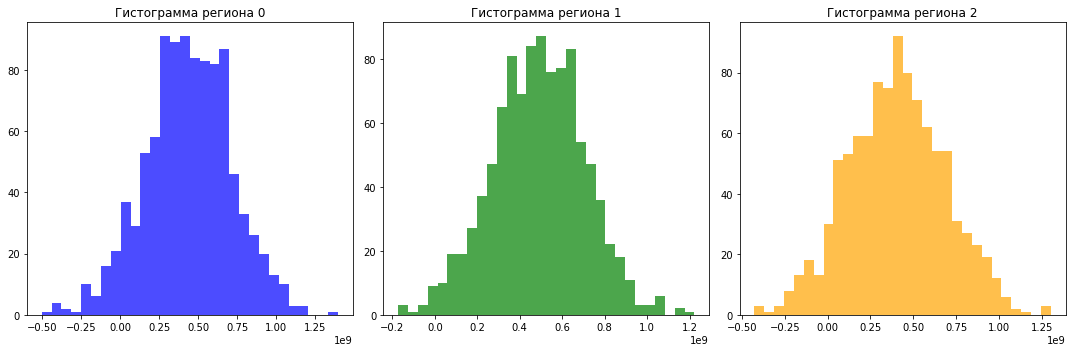

In [25]:
# Визуализация данных с помощью гистограмм
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(values_0, bins=30, color='blue', alpha=0.7)
plt.title('Гистограмма региона 0')

plt.subplot(1, 3, 2)
plt.hist(values_1, bins=30, color='green', alpha=0.7)
plt.title('Гистограмма региона 1')

plt.subplot(1, 3, 3)
plt.hist(values_2, bins=30, color='orange', alpha=0.7)
plt.title('Гистограмма региона 2')

plt.tight_layout()
plt.show()

По результатам оценки трех регионов с точки зрения потенциальной прибыли и рисков убытков, можно сделать следующие выводы:

Средняя прибыль лучших месторождений:

Регион 1: 435,933,771.699 рублей\
Регион 2: 489,661,253.932 рублей\
Регион 3: 403,687,927.423 рублей

95% доверительный интервал для средней прибыли 200 лучших месторождений:

Регион 1: (-116,231,612.07, 966,504,179.85) рублей\
Регион 2: (55,116,176.63, 905,762,649.95) рублей\
Регион 3: (-153,116,984.07, 952,887,416.38) рублей

Риски убытков:

Регион 1: 6.1%\
Регион 2: 1.1%\
Регион 3: 7.1%

Таким образом, на основе новых данных рекомендуется выбрать Регион 1 для дальнейшей разработки скважин, \
поскольку он обладает наивысшей средней прибылью, но так же можно выбрать регион 2 - он обладает\
минимальным риском убытков по сравнению с другими регионами.

#### Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован